In [117]:
import os
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pydot
import cv2


In [118]:

with zipfile.ZipFile( '/Users/clara_bourdon/Downloads/trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [119]:
root_dir = './trafficsigns_dataset'

# Liste pour stocker les noms des images, sous-dossiers et dossiers principaux
image_names = []
subfolder_names = []
folder_names = []
image_path = []

for root, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            image_names.append(file)
            subfolder_names.append(os.path.basename(root))
            folder_names.append(os.path.basename(os.path.dirname(root)))
            image_path.append('./trafficsigns_dataset/' + str(os.path.basename(os.path.dirname(root)) + '/' + str(os.path.basename(root)) + '/'  + str(file)))


data= pd.DataFrame({
    'Image_name': image_names,
    'Subfolder_Name': subfolder_names,
    'Folder_Name': folder_names,
    'Image_path' : image_path
})
data.head()

,Image_name,Subfolder_Name,Folder_Name,Image_path
0,00039_00001.png,rightofway,diamond,./trafficsigns_dataset/diamond/rightofway/0003...
1,01803_00002.png,rightofway,diamond,./trafficsigns_dataset/diamond/rightofway/0180...
2,01702_00000.png,rightofway,diamond,./trafficsigns_dataset/diamond/rightofway/0170...
3,00111_00001.png,rightofway,diamond,./trafficsigns_dataset/diamond/rightofway/0011...
4,01231_00003.png,rightofway,diamond,./trafficsigns_dataset/diamond/rightofway/0123...


In [120]:
data.shape

(3699, 4)

#EDA

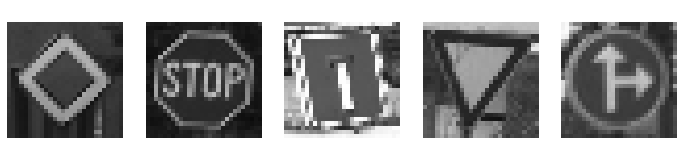

In [121]:
images_by_shape = {}

for index, row in data.iterrows():
    shape = row['Folder_Name']
    image_path = row['Image_path']
    
    if shape not in images_by_shape:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        images_by_shape[shape] = image

plt.figure(figsize=(12, 4))
for i, (shape, image) in enumerate(images_by_shape.items()):
    plt.subplot(1, len(images_by_shape), i+1)
    plt.imshow(image)
    plt.title(shape, color='white')
    plt.axis('off')

plt.show()

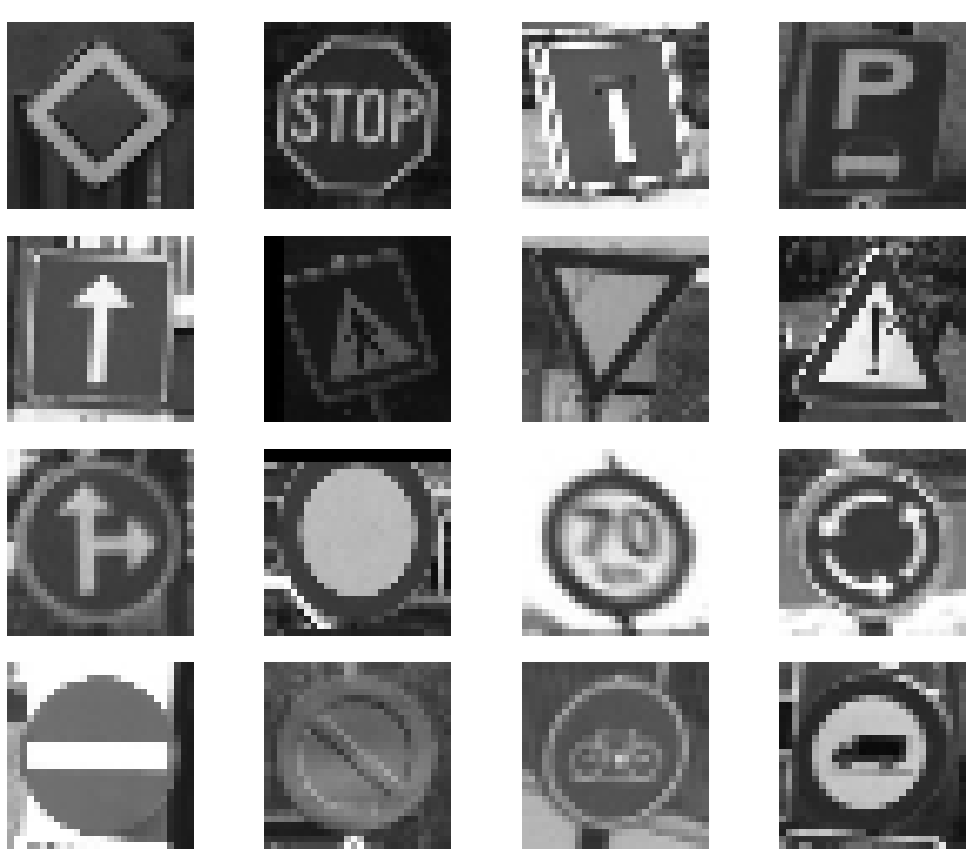

In [122]:
images_by_type = {}

for index, row in data.iterrows():
    type = row['Subfolder_Name']
    image_path = row['Image_path']
    
    if type not in images_by_type:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
        images_by_type[type] = image

num_per_row = 4
num_rows = (len(images_by_type) + num_per_row - 1) // num_per_row

plt.figure(figsize=(15, 3*num_rows))
for i, (type, image) in enumerate(images_by_type.items()):
    plt.subplot(num_rows, num_per_row, i+1)
    plt.imshow(image)
    plt.title(type, color='white')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [123]:
data.isnull().sum()

Image_name        0
Subfolder_Name    0
Folder_Name       0
Image_path        0
dtype: int64

Pas de données manquantes

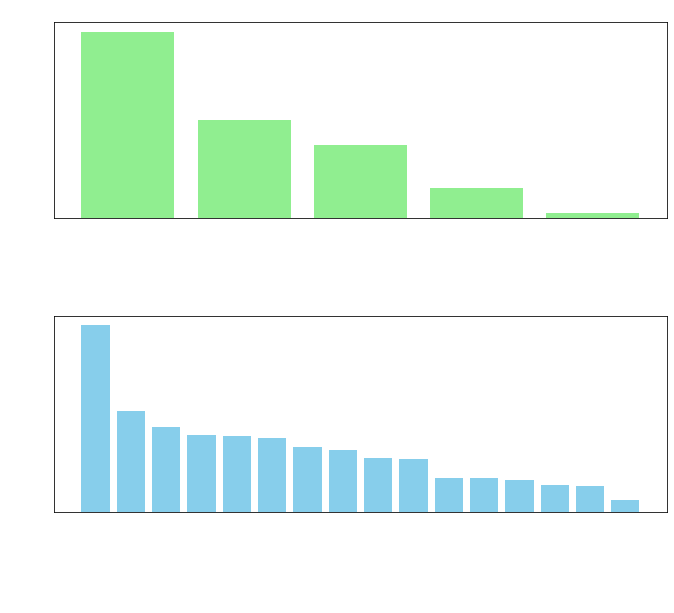

In [124]:
value_counts_b = data['Subfolder_Name'].value_counts()

value_counts_a = data['Folder_Name'].value_counts()

fig, axs = plt.subplots(2, 1, figsize=(11, 9))

# Premier sous-graphique pour la première série de value_counts()
axs[0].bar(value_counts_a.index, value_counts_a.values, color='lightgreen')
axs[0].set_title('Value Counts - Shape', color='white')
axs[0].set_xlabel('Category', color='white')
axs[0].set_ylabel('Count', color='white')
axs[0].tick_params(axis='x', colors='white')
axs[0].tick_params(axis='y', colors='white')

axs[1].bar(value_counts_b.index, value_counts_b.values, color='skyblue')
axs[1].set_title('Value Counts - Type', color='white')
axs[1].set_xlabel('Group', color='white')
axs[1].set_ylabel('Count', color='white')
axs[1].tick_params(axis='x', colors='white', rotation=90)
axs[1].tick_params(axis='y', colors='white')

plt.subplots_adjust(hspace=0.5)

plt.show()


In [125]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 2219, Val Data: 740, Test Data: 740


# On commence le code

In [126]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')
    plt.gca().title.set_color('white')
    plt.gca().xaxis.label.set_color('white')
    plt.gca().yaxis.label.set_color('white')
    plt.gca().tick_params(axis='x', colors='white')
    plt.gca().tick_params(axis='y', colors='white')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.gca().title.set_color('white')
    plt.gca().xaxis.label.set_color('white')
    plt.gca().yaxis.label.set_color('white')
    plt.gca().tick_params(axis='x', colors='white')
    plt.gca().tick_params(axis='y', colors='white')

    plt.show()

In [127]:
INPUT_DIM = (32,32,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 5

In [128]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.16.1'

In [129]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [130]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 787,973 (3.01 MB)

 Trainable params: 787,973 (3.01 MB)

 Non-trainable params: 0 (0.00 B)

In [131]:
hasattr(pydot, 'InvocationException')


False

In [132]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [133]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [134]:
train_data['Folder_Name'] = train_data['Folder_Name'].astype('str')
val_data['Folder_Name'] = val_data['Folder_Name'].astype('str')
train_data.head()

,Image_name,Subfolder_Name,Folder_Name,Image_path
3009,01483_00001.png,noparking,round,./trafficsigns_dataset/round/noparking/01483_0...
2409,00937_00000.png,speed,round,./trafficsigns_dataset/round/speed/00937_00000...
966,00791_00002.png,crossing,square,./trafficsigns_dataset/square/crossing/00791_0...
1307,01081_00001.png,warning,triangle,./trafficsigns_dataset/triangle/warning/01081_...
1798,00567_00002.png,warning,triangle,./trafficsigns_dataset/triangle/warning/00567_...


In [135]:

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_path",
        y_col="Folder_Name",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_path",
        y_col="Folder_Name",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 5 classes.
Found 740 validated image filenames belonging to 5 classes.


In [136]:

history = model.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


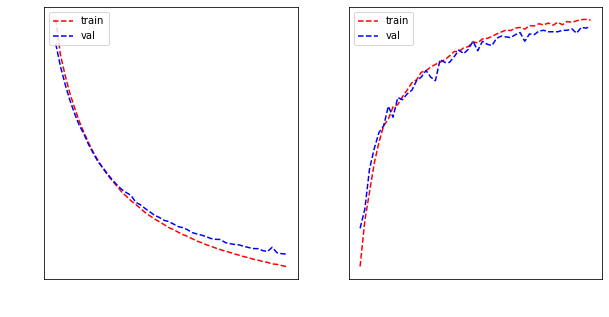

In [137]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Testing 

In [138]:
test_data['Folder_Name'] = test_data['Folder_Name'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_path",
        y_col="Folder_Name",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 5 classes.


In [139]:
model.evaluate(test_generator)

378/740 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - categorical_accuracy: 0.9391 - loss: 0.2870

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - categorical_accuracy: 0.9374 - loss: 0.2869


[0.29342928528785706, 0.933783769607544]

# on plot des resultats

In [140]:
label_names = {'diamond' : 0, 'hex' : 1, 'round' : 2, 'square' : 3, 'triangle' : 4}

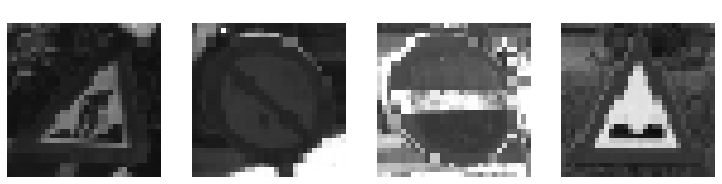

In [141]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ), color='white')

            
        else:
            break
        
        plt.axis('off')

# ATTENTION
La on se base sur categorical_accuracy mais je crois qu'il faut en choisir un et justifier de son choix. Il y a aussi f1 jsp quoi, surement ce qur tom à prit, donc peut être se pencher sur la question

# On passe à la prédiction du type


In [150]:
INPUT_DIM = (32,32,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 16

In [151]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.16.1'

In [169]:
model_type = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [170]:
model_type.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │         4,112 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 790,800 (3.02 MB)

 Trainable params: 790,800 (3.02 MB)

 Non-trainable params: 0 (0.00 B)

In [171]:
model_type.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [172]:
train_data['Subfolder_Name'] = train_data['Subfolder_Name'].astype('str')
val_data['Subfolder_Name'] = val_data['Subfolder_Name'].astype('str')
train_data.head()

,Image_name,Subfolder_Name,Folder_Name,Image_path
3009,01483_00001.png,noparking,round,./trafficsigns_dataset/round/noparking/01483_0...
2409,00937_00000.png,speed,round,./trafficsigns_dataset/round/speed/00937_00000...
966,00791_00002.png,crossing,square,./trafficsigns_dataset/square/crossing/00791_0...
1307,01081_00001.png,warning,triangle,./trafficsigns_dataset/triangle/warning/01081_...
1798,00567_00002.png,warning,triangle,./trafficsigns_dataset/triangle/warning/00567_...


In [156]:

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="Image_path",
        y_col="Subfolder_Name",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="Image_path",
        y_col="Subfolder_Name",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 2219 validated image filenames belonging to 16 classes.
Found 740 validated image filenames belonging to 16 classes.


In [173]:
history = model_type.fit(train_generator, validation_data=validation_generator, epochs=50, verbose=0)
#history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


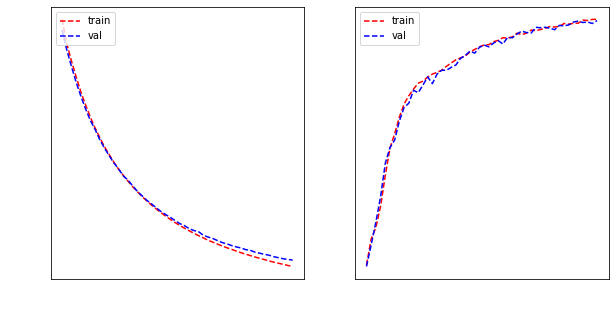

In [174]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

# Testing

In [160]:
test_data['Subfolder_Name'] = test_data['Subfolder_Name'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="Image_path",
        y_col="Subfolder_Name",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 740 validated image filenames belonging to 16 classes.


In [175]:
model_type.evaluate(test_generator)

740/740 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step - categorical_accuracy: 0.8682 - loss: 0.6709


[0.5930911302566528, 0.8783783912658691]

In [164]:
label_names = {'rightofway' : 0, 'stop' : 1, 'bicycle' : 2, 'limitedtraffic' : 3, 'noentry' : 4, 'noparking' : 5, 'roundabout' : 6, 'speed' : 7, 'trafficdirective' : 8, 'traveldirection' : 9,'continue' : 10, 'crossing' : 11, 'laneend' : 12, 'parking' : 13, 'giveway' : 14, 'warning' : 15 }

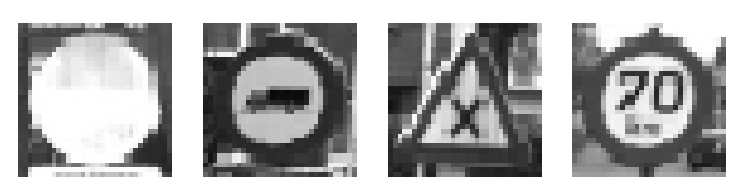

In [177]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_type.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ), color='white')

            
        else:
            break
        
        plt.axis('off')